# Data Import and Pre-Processing

In [1]:
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Setting up Spark Session
spark = SparkSession.builder.appName('olistRFM').getOrCreate()

In [3]:
#Importing Orders Data set
dfOrders = spark.read.csv('olist_orders_dataset.csv', header=True, inferSchema=True)

In [4]:
dfOrders.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



In [5]:
#Importing Payments Data set
dfOrdersPayment = spark.read.csv('olist_order_payments_dataset.csv', header=True, inferSchema=True)

In [6]:
dfOrdersPayment.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- payment_sequential: integer (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: integer (nullable = true)
 |-- payment_value: double (nullable = true)



In [7]:
dfOrders.count()

99441

In [8]:
dfOrdersPayment.count()

103886

In [9]:
dfOrders.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:33|2017-10-02 11:07:15|         2017-10-04 19:55:00|          2017-10-10 21:25:13|          2017-10-18 00:00:00|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:37|2018-07-26 03:24:27|         2018-07-26 14:31:00|          2018-08-07 15:27:45|          2018-08-13 00:00:00|
|47770eb9100c2d0c4...|41ce2a54c0b03bf34...|  

In [10]:
dfOrdersPayment.show(5)

+--------------------+------------------+------------+--------------------+-------------+
|            order_id|payment_sequential|payment_type|payment_installments|payment_value|
+--------------------+------------------+------------+--------------------+-------------+
|b81ef226f3fe1789b...|                 1| credit_card|                   8|        99.33|
|a9810da82917af2d9...|                 1| credit_card|                   1|        24.39|
|25e8ea4e93396b6fa...|                 1| credit_card|                   1|        65.71|
|ba78997921bbcdc13...|                 1| credit_card|                   8|       107.78|
|42fdf880ba16b47b5...|                 1| credit_card|                   2|       128.45|
+--------------------+------------------+------------+--------------------+-------------+
only showing top 5 rows



In [11]:
#Joining Orders and Payments data set on OderId - Master Data
df = dfOrders.join(dfOrdersPayment,on='order_id',how='inner')

In [12]:
df.count()

103886

In [13]:
#Computing Distinct Orders by Order Ids
df.select('order_id').distinct().count()

99440

In [159]:
#Computing Order's Frequency
orderFrequency = df.groupBy('order_id').count().orderBy('count', ascending = False).select('count')

In [15]:
type(orderFrequency)

pyspark.sql.dataframe.DataFrame

In [16]:
data = orderFrequency.collect()

In [18]:
#Dropping unnecessary Columns in Master Data
df = df.drop("order_delivered_carrier_date","order_approved_at","order_delivered_customer_date","order_estimated_delivery_date","payment_installments","payment_sequential")

In [19]:
#Defining Order Frequency by Unique Customers
custumerOrdersCount = df.select("customer_id").groupby("customer_id").count().orderBy("count",ascending=False)

In [20]:
#Defining Max. Payment value by customers
custumerOrdersPayment = df.groupby("customer_id").max("payment_value")

In [21]:
joinResult = custumerOrdersCount.join(custumerOrdersPayment, on ="customer_id", how="inner")

In [22]:
#Storing Order Count and Corresponding Frequency
joinResult=joinResult.withColumnRenamed('count','frequency')

In [23]:
import numpy as np
import datetime
from pyspark.sql.functions import year, month, dayofmonth

#Computing Recency across each customer - Considering Recent order placed/delivered to a Customer
df = df.withColumn("order_purchase_timestamp",df["order_purchase_timestamp"].cast("double"))
OrderRecent = df.groupBy("customer_id").max("order_purchase_timestamp")
OrderRecent=OrderRecent.withColumn("max(order_purchase_timestamp)",OrderRecent["max(order_purchase_timestamp)"].cast("timestamp"))
OrderRecent = OrderRecent.withColumnRenamed("max(order_purchase_timestamp)","time_stamp")
OrderRecent.show()

+--------------------+-------------------+
|         customer_id|         time_stamp|
+--------------------+-------------------+
|f54a9f0e6b351c431...|2017-01-23 18:29:09|
|2a1dfb647f32f4390...|2018-06-01 12:23:13|
|4f28355e5c17a4a42...|2017-05-18 13:55:47|
|4632eb5a8f175f6fe...|2017-11-30 22:02:15|
|843ff05b30ce4f75b...|2017-11-13 10:07:36|
|a4156bb8aff5d6722...|2017-09-26 11:08:38|
|1099d033c74a027a7...|2018-01-27 22:09:48|
|7a3bd3b37285f0ab2...|2017-03-09 16:43:40|
|5fff39f1b59dc4d2f...|2017-05-01 19:13:37|
|18f6ca10777417c93...|2018-01-18 14:40:57|
|f1e46939e6408b3e6...|2017-06-01 14:58:11|
|a8695124db570d100...|2017-11-22 16:56:05|
|545b9a267af9ba134...|2018-02-14 10:48:33|
|90d7075599361b694...|2017-07-28 17:03:33|
|a340ce6c3570e68d4...|2018-04-18 14:29:17|
|ce0681e1c3f70e145...|2017-12-19 16:58:22|
|ee905ec97794ec6e9...|2017-06-18 17:55:19|
|b74ca180d63f9ae04...|2018-01-30 09:43:45|
|0de46efc7d10114ac...|2017-03-23 13:25:32|
|8bdae6b4ff9bc7f4c...|2017-11-24 23:30:13|
+----------

In [23]:
OrderRecent.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- time_stamp: timestamp (nullable = true)



In [24]:
joinResult.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- frequency: long (nullable = false)
 |-- max(payment_value): double (nullable = true)



In [25]:
#Combining Frequency, Recency and Monetary attributes computed above 
finalDf = joinResult.join(OrderRecent, on = 'customer_id')

In [26]:
finalDf.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- frequency: long (nullable = false)
 |-- max(payment_value): double (nullable = true)
 |-- time_stamp: timestamp (nullable = true)



In [27]:
finalDf = finalDf.withColumnRenamed('max(payment_value)','monetary')
finalDf = finalDf.withColumnRenamed('time_stamp','recency')

In [28]:
#Collated Frequency, Recemcy and Monetary values across each customer on Customer ID
finalDf.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary: double (nullable = true)
 |-- recency: timestamp (nullable = true)



In [27]:
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.mllib.linalg import Vectors

In [30]:
finalDf.select('recency').show(1)

+-------------------+
|            recency|
+-------------------+
|2017-11-29 00:11:03|
+-------------------+
only showing top 1 row



In [31]:
finalDf

DataFrame[customer_id: string, frequency: bigint, monetary: double, recency: timestamp]

In [32]:
finalDf.head()

Row(customer_id=u'01d190d14b00073f76e0a5ec46166352', frequency=1, monetary=258.74, recency=datetime.datetime(2017, 11, 29, 0, 11, 3))

In [41]:
#Defining a Function which will calculate the time difference between recent purchase 
#time and Epoch Time (00:00:00 Thursday, 1 January 1970) and scaling it down by divinding 100 

def returnEpoch(dt):
    return ((dt - datetime.datetime(1970, 1, 1,0,0,0)).total_seconds())/(604800*100)
def returnRows(x):
    return float(x[1]),float(x[2]),float(returnEpoch(x[3])),str(x[0])

In [42]:
finalDfrdd = finalDf.rdd.map(lambda x: returnRows(x))

In [43]:
finalDfrdd.take(3)

[(1.0, 258.74, 24.998582390873015, '01d190d14b00073f76e0a5ec46166352'),
 (1.0, 198.1, 25.28519419642857, '03a7750fc7a7bfbd7a84b2f4f26b92f1'),
 (1.0, 265.04, 25.205229894179894, '04495037fc6899faffa41ba3bc4272b4')]

In [44]:
#Converting RDD to DF
finalDf = finalDfrdd.toDF()

In [45]:
finalDf.show(1)

+---+------+------------------+--------------------+
| _1|    _2|                _3|                  _4|
+---+------+------------------+--------------------+
|1.0|258.74|24.998582390873015|01d190d14b00073f7...|
+---+------+------------------+--------------------+
only showing top 1 row



In [46]:
finalDf = finalDf.withColumnRenamed('_1','frequency')
finalDf = finalDf.withColumnRenamed('_2','monetary')
finalDf = finalDf.withColumnRenamed('_3','recency')
finalDf = finalDf.withColumnRenamed('_4','customer_id')

In [47]:
finalDf.head()

Row(frequency=1.0, monetary=258.74, recency=24.998582390873015, customer_id=u'01d190d14b00073f76e0a5ec46166352')

In [48]:
finalDf.describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|         frequency|          monetary|           recency|         customer_id|
+-------+------------------+------------------+------------------+--------------------+
|  count|             99440|             99440|             99440|               99440|
|   mean|1.0447103781174578|159.47379143201914| 25.04481155404425|                null|
| stddev|0.3811656306568635|220.36965405933074|0.2195181220522018|                null|
|    min|               1.0|               0.0|24.355550909391535|00012a2ce6f8dcda2...|
|    max|              29.0|          13664.08|25.459613392857143|ffffe8b65bbe3087b...|
+-------+------------------+------------------+------------------+--------------------+



In [49]:
#Selecting Parameters for running K-Means Clustering algorithms
clusterData = finalDf.select('frequency','monetary','recency')

In [51]:
clusterData.head()

Row(frequency=1.0, monetary=258.74, recency=24.998582390873015)

# Data Pipeline

In [52]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [53]:
clusterData.columns

['frequency', 'monetary', 'recency']

In [54]:
vec_assembler = VectorAssembler(inputCols = clusterData.columns, outputCol='features')

In [55]:
final_data = vec_assembler.transform(clusterData)

In [56]:
final_data.head()

Row(frequency=1.0, monetary=258.74, recency=24.998582390873015, features=DenseVector([1.0, 258.74, 24.9986]))

In [114]:
type(final_data)

pyspark.sql.dataframe.DataFrame

# Scaling Features

In [58]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [59]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [118]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

IllegalArgumentException: u'requirement failed: Output column scaledFeatures already exists.'

In [119]:
final_data.show(2)

+---------+--------+------------------+--------------------+--------------------+
|frequency|monetary|           recency|            features|      scaledFeatures|
+---------+--------+------------------+--------------------+--------------------+
|      1.0|  258.74|24.998582390873015|[1.0,258.74,24.99...|[2.62353139834957...|
|      1.0|   198.1| 25.28519419642857|[1.0,198.1,25.285...|[2.62353139834957...|
+---------+--------+------------------+--------------------+--------------------+
only showing top 2 rows



# K-Means Cluster and Evaluation 

In [65]:
#final_data.take(3)

[Row(frequency=1.0, monetary=258.74, recency=24.998582390873015, features=DenseVector([1.0, 258.74, 24.9986]), scaledFeatures=DenseVector([2.6235, 1.1741, 113.8794])),
 Row(frequency=1.0, monetary=198.1, recency=25.28519419642857, features=DenseVector([1.0, 198.1, 25.2852]), scaledFeatures=DenseVector([2.6235, 0.8989, 115.185])),
 Row(frequency=1.0, monetary=265.04, recency=25.205229894179894, features=DenseVector([1.0, 265.04, 25.2052]), scaledFeatures=DenseVector([2.6235, 1.2027, 114.8207]))]

In [167]:
#Defining a function that would compute Clusters, Within Sum squared errors and store them
cp=0
kdict = {}
def elbowDict(n):
    k = 2
    cp=0
    while(k < n):
        kmeans = KMeans(featuresCol='scaledFeatures',k=k)
        model = kmeans.fit(final_data)
        wssse = model.computeCost(final_data)
        kdict[k] = wssse
        k = k + 1
        cp=cp+1
        print(cp)

In [168]:
elbowDict(13)

1
2
3
4
5
6
7
8
9
10
11


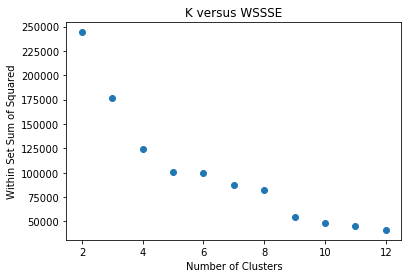

In [169]:
plt.scatter(kdict.keys(),kdict.values())
plt.title("K versus WSSSE")
plt.xlabel('Number of Clusters')
plt.ylabel('Within Set Sum of Squared')
plt.show()

In [ ]:
#WSSSE across cluster
print(kdict.keys(),kdict.values())

In [140]:
# Trains a k-means models at K = 9 as per above 
kmeans = KMeans(featuresCol='scaledFeatures',k=9)
model = kmeans.fit(final_data)

In [141]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(final_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 54206.4997857


In [143]:
#k1 = model.transform(final_data).filter('prediction = 2').count()
k9 = model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 4283|
|         6|    6|
|         3|   37|
|         5|34900|
|         4|  235|
|         8| 2631|
|         7|  491|
|         2|22106|
|         0|34751|
+----------+-----+



In [147]:
model.clusterCenters()

[array([   2.6235314 ,    0.57176185,  115.09242665]),
 array([   2.64929439,    3.31078659,  114.15745278]),
 array([   2.6235314 ,    0.57271441,  112.66677659]),
 array([  29.21337665,    0.23220198,  113.39929553]),
 array([  13.30744437,    0.22238707,  113.90834878]),
 array([   2.6235314 ,    0.55199951,  113.99526515]),
 array([  59.4667117 ,    0.17984176,  113.0481498 ]),
 array([   2.67718235,    9.68971165,  114.08955612]),
 array([   5.54720835,    0.45681067,  113.9595196 ])]

In [148]:
k9 = model.transform(final_data)

In [149]:
columns = k9.columns; columns

['frequency',
 'monetary',
 'recency',
 'features',
 'scaledFeatures',
 'prediction']

In [150]:
#def parsedK(x):
  # return (float(x[0]),float(x[1]),float(x[2]),int(x[5]))

In [151]:
k9 = k9.rdd.map(lambda x: parsedK(x))

In [152]:
k9.take(4)

[(1.0, 258.74, 24.998582390873015, 5),
 (1.0, 198.1, 25.28519419642857, 0),
 (1.0, 265.04, 25.205229894179894, 0),
 (1.0, 372.56, 24.66654138558201, 2)]

In [153]:
k9 = k9.toDF()

In [155]:
k9.show(5)

+---+------+------------------+---+
| _1|    _2|                _3| _4|
+---+------+------------------+---+
|1.0|258.74|24.998582390873015|  5|
|1.0| 198.1| 25.28519419642857|  0|
|1.0|265.04|25.205229894179894|  0|
|1.0|372.56| 24.66654138558201|  2|
|1.0|340.72| 25.28104353505291|  0|
+---+------+------------------+---+
only showing top 5 rows



In [156]:
k9 = k9.withColumnRenamed('_1', 'frequency')
k9 = k9.withColumnRenamed('_2', 'monetary')
k9 = k9.withColumnRenamed('_3', 'recency')
k9 = k9.withColumnRenamed('_4', 'prediction')

# Cluster 0 - 'The One Timers'

In [157]:
k9.filter('prediction = 0').summary().show()

+-------+---------+------------------+-------------------+----------+
|summary|frequency|          monetary|            recency|prediction|
+-------+---------+------------------+-------------------+----------+
|  count|    34751|             34751|              34751|     34751|
|   mean|      1.0|125.94268567811002| 25.264942048610585|       0.0|
| stddev|      0.0| 86.92686337949276|0.07144365351539089|       0.0|
|    min|      1.0|               0.0|  25.13985246362434|         0|
|    25%|      1.0|             61.23|  25.20343576388889|         0|
|    50%|      1.0|            102.94| 25.264124619708994|         0|
|    75%|      1.0|            166.44|   25.3324072255291|         0|
|    max|      1.0|            497.25| 25.459613392857143|         0|
+-------+---------+------------------+-------------------+----------+



# Cluster 1 = Recent and Moderate valued customers

In [166]:
k9.filter('prediction = 1').summary().show()

+-------+-------------------+------------------+-------------------+----------+
|summary|          frequency|          monetary|            recency|prediction|
+-------+-------------------+------------------+-------------------+----------+
|  count|               4283|              4283|               4283|      4283|
|   mean| 1.0098062106000467|  728.758615456456|  25.05977709523514|       1.0|
| stddev|0.09855108562094252|242.82503242678845|0.20356920639532186|       0.0|
|    min|                1.0|            420.62| 24.398299090608464|         1|
|    25%|                1.0|            541.97| 24.926510201719577|         1|
|    50%|                1.0|            658.29|  25.08705343915344|         1|
|    75%|                1.0|            858.65| 25.221109738756613|         1|
|    max|                2.0|           1432.92| 25.389422999338624|         1|
+-------+-------------------+------------------+-------------------+----------+



In [158]:
k9.filter('prediction = 2').summary().show()

+-------+---------+------------------+-------------------+----------+
|summary|frequency|          monetary|            recency|prediction|
+-------+---------+------------------+-------------------+----------+
|  count|    22106|             22106|              22106|     22106|
|   mean|      1.0|126.22891522663528| 24.732555358117445|       2.0|
| stddev|      0.0|  93.5958979532493|0.09903772904699851|       0.0|
|    min|      1.0|             11.62| 24.355550909391535|         2|
|    25%|      1.0|             59.69| 24.659755886243385|         2|
|    50%|      1.0|             98.88|  24.74274722222222|         2|
|    75%|      1.0|            162.32| 24.816283597883597|         2|
|    max|      1.0|            676.92| 24.882439732142856|         2|
+-------+---------+------------------+-------------------+----------+



In [160]:
k9.filter('prediction = 3').summary().show()

+-------+------------------+-----------------+-------------------+----------+
|summary|         frequency|         monetary|            recency|prediction|
+-------+------------------+-----------------+-------------------+----------+
|  count|                37|               37|                 37|        37|
|   mean|11.135135135135135|51.17027027027027| 24.893200395931643|       3.0|
| stddev|1.7505897762081681|84.68218553596233|0.20878174643130534|       0.0|
|    min|               9.0|             4.68| 24.563928191137567|         3|
|    25%|              10.0|            15.67|  24.73655411706349|         3|
|    50%|              11.0|            29.18| 24.824970238095236|         3|
|    75%|              12.0|            54.03| 25.002523660714285|         3|
|    max|              15.0|           455.86| 25.298495568783068|         3|
+-------+------------------+-----------------+-------------------+----------+



In [161]:
k9.filter('prediction = 4').summary().show()

+-------+-----------------+-----------------+-------------------+----------+
|summary|        frequency|         monetary|            recency|prediction|
+-------+-----------------+-----------------+-------------------+----------+
|  count|              235|              235|                235|       235|
|   mean|5.072340425531915|49.00736170212764|  25.00494681048071|       4.0|
| stddev|1.229568426763568|61.91839956729704|0.22980833844390278|       0.0|
|    min|              4.0|             4.34| 24.397939417989416|         4|
|    25%|              4.0|            18.75| 24.815078406084655|         4|
|    50%|              5.0|            27.39|  25.01095892857143|         4|
|    75%|              6.0|            56.72|  25.20212476851852|         4|
|    max|              8.0|           486.55| 25.382415922619046|         4|
+-------+-----------------+-----------------+-------------------+----------+



# Cluster - 5 : One Timers-High Valued Customers- Recent Customers

In [162]:
k9.filter('prediction = 5').summary().show()

+-------+---------+------------------+-------------------+----------+
|summary|frequency|          monetary|            recency|prediction|
+-------+---------+------------------+-------------------+----------+
|  count|    34900|             34900|              34900|     34900|
|   mean|      1.0|121.61051690544416|  25.02419127848225|       5.0|
| stddev|      0.0|  83.1499071150848|0.07390623084278554|       0.0|
|    min|      1.0|             10.07| 24.876840889550266|         5|
|    25%|      1.0|             59.98| 24.971245287698412|         5|
|    50%|      1.0|             98.79| 25.020524735449737|         5|
|    75%|      1.0|            161.77| 25.088398726851853|         5|
|    max|      1.0|            433.28| 25.145801802248677|         5|
+-------+---------+------------------+-------------------+----------+



# Cluster 6 - High-Frequency Customers

In [163]:
k9.filter('prediction = 6').summary().show()

+-------+------------------+-----------------+-------------------+----------+
|summary|         frequency|         monetary|            recency|prediction|
+-------+------------------+-----------------+-------------------+----------+
|  count|                 6|                6|                  6|         6|
|   mean|22.666666666666668|39.63166666666667| 24.816117545745147|       6.0|
| stddev| 4.033195589934447|54.86145437979809|0.12660435981132187|       0.0|
|    min|              19.0|             4.07|  24.68075949074074|         6|
|    25%|              19.0|            12.49|  24.71240560515873|         6|
|    50%|              21.0|             16.7|  24.74929083994709|         6|
|    75%|              26.0|            31.43|  24.90374677579365|         6|
|    max|              29.0|            150.0|  25.01214292328042|         6|
+-------+------------------+-----------------+-------------------+----------+



# Cluster 7 - The High-Money Valued Customers

In [164]:
k9.filter('prediction = 7').summary().show()

+-------+-------------------+-----------------+-------------------+----------+
|summary|          frequency|         monetary|            recency|prediction|
+-------+-------------------+-----------------+-------------------+----------+
|  count|                491|              491|                491|       491|
|   mean| 1.0203665987780042|2132.463767820774| 25.045241637403155|       7.0|
| stddev|0.14139490228535692|933.9753363178604|0.23576027857166046|       0.0|
|    min|                1.0|          1433.04| 24.560981646825397|         7|
|    25%|                1.0|          1642.54| 24.884108697089946|         7|
|    50%|                1.0|          1916.08|  25.07677037037037|         7|
|    75%|                1.0|          2252.66| 25.246603869047618|         7|
|    max|                2.0|         13664.08| 25.400643055555555|         7|
+-------+-------------------+-----------------+-------------------+----------+



In [165]:
k9.filter('prediction = 8').summary().show()

+-------+-------------------+------------------+-------------------+----------+
|summary|          frequency|          monetary|            recency|prediction|
+-------+-------------------+------------------+-------------------+----------+
|  count|               2631|              2631|               2631|      2631|
|   mean|   2.11440516913721|100.66721018624096| 25.016179731689107|       8.0|
| stddev|0.31836323569783037| 97.58335911617557|0.22183701541803497|       0.0|
|    min|                2.0|              7.02| 24.398179712301587|         8|
|    25%|                2.0|             42.02| 24.842821312830687|         8|
|    50%|                2.0|             69.99|  25.03521840277778|         8|
|    75%|                2.0|             117.8| 25.197754910714284|         8|
|    max|                3.0|            682.97|  25.38808844246032|         8|
+-------+-------------------+------------------+-------------------+----------+

